In [1]:
import sys
from pathlib import Path

from tqdm import tqdm
import toml

import numpy as np

import torch
from torch.utils.data import DataLoader
import torch.optim as optim

from utils import threshold, criterion, norm, unnorm
from dataset_utils import create_dataset,imagenet_loader
from models import load_model
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from torchvision.utils import save_image
# Configure Script
config = toml.load('configs/imagenet/whitebox/imagebind.toml')['general']

gpu_num = config['gpu_num']
epochs = config['epochs']
batch_size = config['batch_size']
eps = config['epsilon']
zero_shot_steps = config['zero_shot_steps']
lr = config['lr']
eta_min = config['eta_min']
seed = config['seed']
output_dir = config['output_dir']
n_images = config['number_images']
buffer_size = config['buffer_size']
delta = config['delta']
model_flag = config.get('model_flag', 'imagebind')
embs_input = config.get('embeddings_input', output_dir + 'embs.npy')\
                   .format(model_flag)
gamma_epochs = config.get('gamma_epochs', 100)
modality = config.get('modality', 'vision')
dataset_flag = config.get('dataset_flag', 'imagenet')

if modality == 'vision':
    eps = eps / 255

if type(epochs) == list:
    max_epochs = max(epochs)
else:
    max_epochs = epochs
    epochs = [epochs]

Path(output_dir).mkdir(parents=True, exist_ok=True)

device = f"cuda:{gpu_num}" if torch.cuda.is_available() and gpu_num >= 0 else "cpu"
assert n_images % batch_size == 0

# Instantiate Model
model = load_model(model_flag, device)

/home/tz362/anaconda3/envs/adversarial_illuisions/lib/python3.10/site-packages/torchvision/transforms/_functional_video.py:6: UserWarning: The 'torchvision.transforms._functional_video' module is deprecated since 0.12 and will be removed in the future. Please use the 'torchvision.transforms.functional' module instead.
  warnings.warn(
/home/tz362/anaconda3/envs/adversarial_illuisions/lib/python3.10/site-packages/torchvision/transforms/_transforms_video.py:22: UserWarning: The 'torchvision.transforms._transforms_video' module is deprecated since 0.12 and will be removed in the future. Please use the 'torchvision.transforms' module instead.
  warnings.warn(


  0%|          | 0.00/4.47G [00:00<?, ?B/s]

  0%|          | 0/2000 [00:00<?, ?it/s, loss=tensor([0.8959]), eta=0.02]

100%|██████████| 2000/2000 [02:14<00:00, 14.88it/s, loss=tensor([0.1212]), eta=0.0106]


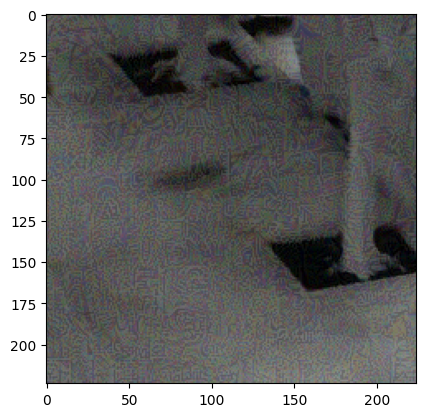

In [5]:
X_path = 'data/assets/street.png'
X=imagenet_loader(X_path,model, device)
X_init = X.clone().detach().cpu().requires_grad_(False)
target_text=["criminal with a gun",]
Y = model.forward(target_text, "text", normalize=False)
X, Y = X.to(device).requires_grad_(True), Y.to(device)

max_epochs=2000
pbar = tqdm(range(max_epochs))
X_init = X.clone().detach().cpu().requires_grad_(False)
X, Y= X.to(device).requires_grad_(True), Y.to(device)
X_max, X_min = threshold(X, eps, modality, device)
optimizer = optim.SGD([X], lr=lr)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer,
                                            np.arange(gamma_epochs, max_epochs, gamma_epochs),
                                            gamma=0.9)
for j in pbar:
    eta = scheduler.get_last_lr()[0]
    embeds = model.forward(X, modality, normalize=False)
    cton = 1 - criterion(embeds, Y, dim=1).detach().cpu()
    loss = 1 - criterion(embeds, Y, dim=1)
    update = eta * torch.autograd.grad(outputs=loss.mean(), inputs=X)[0].sign()
    X = (X.detach().cpu() - update.detach().cpu()).to(device)
    X = torch.clamp(X, min=X_min, max=X_max).requires_grad_(True)
    pbar.set_postfix({'loss': cton, 'eta': eta})
    scheduler.step()

transform = transforms.ToPILImage()
plt.imshow(transform(unnorm(torch.squeeze(X))[0]))
plt.show()
save_image(unnorm(torch.squeeze(X.cuda()))[0], 'outputs/assets/street.png')